<a href="https://colab.research.google.com/github/DanielaDSMS/AN2DL/blob/main/challenge1final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**

In [ ]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/AN2DL/challenge1"
%cd $current_dir

## ⚙️ **Libraries** **Import**

In [ ]:
# =========================
# 0) Standard library
# =========================
import os
import random
import copy
import gc
import logging
import warnings
from itertools import product
from typing import List, Tuple, Dict
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
# =========================
# 1) Environment and warnings
# =========================
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# =========================
# 2) Scientific stack
# =========================
import numpy as np
from scipy.stats import norm, ttest_ind
from scipy.signal import welch
import math

import pandas as pd

# =========================
# 3) Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)

# =========================
# 4) scikit-learn
# =========================
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, classification_report
)

# =========================
# 5) PyTorch
# =========================
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torch.cuda.amp import GradScaler


# Seed everything
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

## ⏳ **Data Loading**

In [ ]:
# Set environment variables for dataset paths
os.environ["TRAIN_FILE"] = "pirate_pain_train.csv"
os.environ["TRAIN_URL"] = "1yRqrSB1JQwH09p1fXpO7lNfQZBl0PSBs"
os.environ["LABEL_FILE"] = "pirate_pain_train_labels.csv"
os.environ["LABEL_URL"] = "1BhWWiWQeBt9R4BcenRjzuuO0-VKQV8oJ"
os.environ["TEST_FILE"] = "pirate_pain_test.csv"
os.environ["TEST_URL"] = "1fXPfRottySriJF2uyRzpUgOI5affanMa"

# Check if Activity Recognition dataset exists and download if not
if not os.path.exists(os.environ["TRAIN_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TRAIN_URL} -O ${TRAIN_FILE}
    print("Activity Recognition dataset1 downloaded!")
else:
    print("Activity Recognition dataset1 already downloaded. Using cached data.")

if not os.path.exists(os.environ["LABEL_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${LABEL_URL} -O ${LABEL_FILE}
    print("Activity Recognition dataset2 downloaded!")
else:
    print("Activity Recognition dataset2 already downloaded. Using cached data.")

if not os.path.exists(os.environ["TEST_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TEST_URL} -O ${TEST_FILE}
    print("Activity Recognition dataset3 downloaded!")
else:
    print("Activity Recognition dataset3 already downloaded. Using cached data.")

## 🔎 **Exploration and Data Analysis**


In [ ]:
# Load the dataset from a CSV file
dataset_train = pd.read_csv('pirate_pain_train.csv')
dataset_labels = pd.read_csv('pirate_pain_train_labels.csv')
dataset_test = pd.read_csv('pirate_pain_test.csv')

# Print the shape of the dataset
print(f"Dataset shape: {dataset_train.shape}")
print(f"Dataset shape: {dataset_labels.shape}")

# Display the first few rows of the dataset
dataset_train.head()

In [ ]:
#Ensure evry recording have same amount of time steps
counts_per_sample = dataset_train.groupby('sample_index')['time'].count()
all_160_timesteps = (counts_per_sample == 160).all()
print(f"All subjects have 160 time steps: {all_160_timesteps}")

In [ ]:
#Ensure that the dataset doesn't contain missing values
print(dataset_train.isna().mean().sort_values(ascending=False).head(10))
print(dataset_train['sample_index'].nunique(), dataset_labels['sample_index'].nunique())

In this piece of code we explored:

- Subject count consistency: Both dataset_train and dataset_labels contain 661 unique sample_index entries, confirming alignment between features and labels.
- No missing values: All columns show a mean of 0.0 for null values, meaning the dataset is clean and doesn't require imputation or removal of NaNs.

dataset_train['sample_index'].nunique() = 661

dataset_labels['sample_index'].nunique() = 661

Let's explore the class imbalance of the data:

In [ ]:
dataset_labels['label'].value_counts()

In [ ]:
dataset_labels['label'].value_counts(normalize=True)

In [ ]:
sns.countplot(data=dataset_labels, x='label')
plt.title('Distribution of the classes')
plt.show()

We explored the dataset and figured out there is significant class imbalance.

That's why we create data imbalance labels of the data:

In [ ]:
classes = np.unique(dataset_labels['label'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=dataset_labels['label']
)
class_weights = dict(zip(classes, class_weights))
print(class_weights)

# **Searching for noisy features**


Finding zero sensors:


In [ ]:
selector = VarianceThreshold(threshold=1e-5)
selector.fit(dataset_train.select_dtypes(float))

low_var_cols = dataset_train.select_dtypes(float).columns[~selector.get_support()]
print("Low variance features:", low_var_cols.tolist())

Finding sensors with unusually large or unstable values:

In [ ]:
stats = dataset_train.describe().T
stats['range'] = stats['max'] - stats['min']
stats['std_over_mean'] = stats['std'] / stats['mean'].abs()

stats[['range', 'std_over_mean']].sort_values('std_over_mean', ascending=False).head(10)

The ones that we need to remove are:

['joint_13','joint_14', 'joint_15','joint_16','joint_18','joint_19','joint_20',
  'joint_21','joint_22','joint_23','joint_24','joint_25','joint_30']

Plot inspection - see the kept-up average line

In [ ]:
subject = dataset_train[dataset_train['sample_index'] == 0]

plt.figure(figsize=(10,5))
plt.plot(subject['time'], subject['joint_00'], label='joint_00')
plt.plot(subject['time'], subject['pain_survey_1'], label='pain_survey_1')
plt.legend()
plt.title('Example signals over time for sample_index = 0')
plt.show()

# **Removing unnecessary or noisy features**


In [ ]:
# List of noisy / unnecessary features
noisy_features = [
    'joint_13', 'joint_14', 'joint_15', 'joint_16',
    'joint_18', 'joint_19', 'joint_20', 'joint_21',
    'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_30'
]

# Remove them off the dataset
dataset_train_clean = dataset_train.drop(columns=[c for c in noisy_features if c in dataset_train.columns], errors='ignore')
dataset_test_clean  = dataset_test.drop(columns=[c for c in noisy_features if c in dataset_test.columns], errors='ignore')

print("✅ Removed noisy features.")
print(f"Original dataset_train shape: {dataset_train.shape}")
print(f"Cleaned  dataset_train shape: {dataset_train_clean.shape}")
print(f"Original dataset_test shape:  {dataset_test.shape}")
print(f"Cleaned  dataset_test shape:  {dataset_test_clean.shape}")


 As we inspected visually in the data, every subject who have at least one disability type have all other ones. That's why we create dataset with "disability" column instead of "n_leg", "n_hands", n_eyes".

In [ ]:
# Copies of train and test sets with disability column
dataset_train_with_disability = dataset_train_clean.copy()
dataset_test_with_disability = dataset_test_clean.copy()

# Anything non-two (eyes, hands, legs)
def is_disabled(value): return value != 'two'

# Every row checks across n_legs, n_hands, n_eyes
dataset_train_with_disability['disability'] = dataset_train_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

dataset_test_with_disability['disability'] = dataset_test_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

# Drop the old columns
dataset_train_with_disability = dataset_train_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])
dataset_test_with_disability = dataset_test_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])

Display new disability set changes:

In [ ]:
print("Original columns:", dataset_train_clean.columns[:10])
print("New columns:", dataset_train_with_disability.columns[:10])
print("Number of disabled subjects entries:", dataset_train_with_disability['disability'].sum())
disabled_subjects = dataset_train_with_disability.groupby('sample_index')['disability'].max().sum()
print("Number of unique disabled subjects:", disabled_subjects)
print("Disabled subjects are this percentage (%) of the total subjects:", disabled_subjects/dataset_train['sample_index'].nunique()*100)
dataset_train_with_disability.head() # Disability column at the end

#**Exploring data properties**

In [ ]:
# ==================== helper functions ====================

def replace_nans_per_channel(X):
    X = X.astype(float)
    if np.isnan(X).any():
        med = np.nanmedian(X, axis=0, keepdims=True)
        X = np.where(np.isnan(X), med, X)
    return X

def average_reference_then_avg_across_channels(X):
    X = np.asarray(X, float)
    X_ref = X - X.mean(axis=1, keepdims=True)
    sig = X_ref.mean(axis=1)
    return sig

def rms_normalize_sample(x):
    x = np.asarray(x, float)
    r = np.sqrt(np.mean(x**2))
    if r == 0 or np.isnan(r):
        return x*0, 0
    return x / r, r

def cumulative_energy(t, p):
    E = np.zeros_like(p)
    dt = np.diff(t)
    incr = 0.5*(p[1:] + p[:-1]) * dt
    E[1:] = np.cumsum(incr)
    return E

def robust_fs_from_time(t):
    dts = np.diff(t)
    dt_med = np.median(dts)
    fs = 1.0 / dt_med
    is_uniform = np.std(dts) <= 0.01*np.mean(dts)
    return fs, dt_med, dts, is_uniform

def resample_to_uniform(t, x):
    fs, dt_med, _, _ = robust_fs_from_time(t)
    n = int(np.floor((t[-1] - t[0]) / dt_med)) + 1
    t_uni = t[0] + np.arange(n) * dt_med
    x_uni = np.interp(t_uni, t, x)
    return t_uni, x_uni, 1.0/dt_med

def fft_power_onesided(x, fs):
    x = np.asarray(x, float)
    n = len(x)
    fft_vals = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, d=1./fs)
    P = (np.abs(fft_vals)**2) / n
    return freqs, P


# ==================== 1) merge data ====================

df = dataset_train_with_disability.merge(dataset_labels, on='sample_index', how='left')
df['is_pain'] = df['label'].map({'no_pain': False, 'low_pain': True, 'high_pain': True})
df = df[~df['is_pain'].isna()].copy()
df['is_pain'] = df['is_pain'].astype(bool)

joint_cols = sorted([c for c in df.columns if c.startswith('joint_')])


# ==================== 2) selecting one pain and one no_pain sample ====================

no_ids = df.loc[~df['is_pain'], 'sample_index'].unique()
yes_ids = df.loc[df['is_pain'],  'sample_index'].unique()

no_pain_id = no_ids[0]
pain_id    = yes_ids[0]

df_no  = df[df['sample_index']==no_pain_id].sort_values('time')
df_yes = df[df['sample_index']==pain_id].sort_values('time')

X_no  = replace_nans_per_channel(df_no[joint_cols].to_numpy(float))
X_yes = replace_nans_per_channel(df_yes[joint_cols].to_numpy(float))

t_no  = df_no['time'].to_numpy(float)
t_yes = df_yes['time'].to_numpy(float)


# ==================== 3) average reference + mean across channels ====================

sig_no_raw  = average_reference_then_avg_across_channels(X_no)
sig_yes_raw = average_reference_then_avg_across_channels(X_yes)


# ==================== 4) --- PLOTS BEFORE RMS NORMALIZATION --- ====================

# --- raw power ---
power_no_raw  = sig_no_raw**2
power_yes_raw = sig_yes_raw**2

# --- raw energy ---
energy_no_raw  = cumulative_energy(t_no,  power_no_raw)
energy_yes_raw = cumulative_energy(t_yes, power_yes_raw)

# --- raw FFT ---
fs_no_raw, _, _, uni_no_raw = robust_fs_from_time(t_no)
fs_yes_raw, _, _, uni_yes_raw = robust_fs_from_time(t_yes)

if not uni_no_raw:
    t_no_u_raw, sig_no_u_raw, fs_no_raw = resample_to_uniform(t_no, sig_no_raw)
else:
    t_no_u_raw, sig_no_u_raw = t_no, sig_no_raw

if not uni_yes_raw:
    t_yes_u_raw, sig_yes_u_raw, fs_yes_raw = resample_to_uniform(t_yes, sig_yes_raw)
else:
    t_yes_u_raw, sig_yes_u_raw = t_yes, sig_yes_raw

freqs_no_raw, P_no_raw = fft_power_onesided(sig_no_u_raw, fs_no_raw)
freqs_yes_raw, P_yes_raw = fft_power_onesided(sig_yes_u_raw, fs_yes_raw)


# ==================== 5) RMS normalization ====================

sig_no,  rms_no  = rms_normalize_sample(sig_no_raw)
sig_yes, rms_yes = rms_normalize_sample(sig_yes_raw)

# power and energy after RMS
power_no  = sig_no**2
power_yes = sig_yes**2

energy_no  = cumulative_energy(t_no,  power_no)
energy_yes = cumulative_energy(t_yes, power_yes)


# ==================== 6) FFT after RMS ====================

fs_no, _, _, uni_no = robust_fs_from_time(t_no)
fs_yes, _, _, uni_yes = robust_fs_from_time(t_yes)

if not uni_no:
    t_no_u, sig_no_u, fs_no = resample_to_uniform(t_no, sig_no)
else:
    t_no_u, sig_no_u = t_no, sig_no

if not uni_yes:
    t_yes_u, sig_yes_u, fs_yes = resample_to_uniform(t_yes, sig_yes)
else:
    t_yes_u, sig_yes_u = t_yes, sig_yes

freqs_no,  P_no  = fft_power_onesided(sig_no_u,  fs_no)
freqs_yes, P_yes = fft_power_onesided(sig_yes_u, fs_yes)


# ==================== 7) --- VISUALIZATION OF EVERYTHING --- ====================

# ---------- RAW ----------
plt.figure(figsize=(9,4))
plt.plot(t_no, sig_no_raw, label="no_pain raw")
plt.plot(t_yes, sig_yes_raw, label="pain raw")
plt.title("Averaged signal (BEFORE RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.semilogy(t_no, power_no_raw, label="no_pain raw")
plt.semilogy(t_yes, power_yes_raw, label="pain raw")
plt.title("Power over time (BEFORE RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(t_no, energy_no_raw, label="no_pain raw")
plt.plot(t_yes, energy_yes_raw, label="pain raw")
plt.title("Energy over time (BEFORE RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.semilogy(freqs_no_raw, P_no_raw, label="no_pain raw")
plt.semilogy(freqs_yes_raw, P_yes_raw, label="pain raw")
plt.title("FFT power spectrum (BEFORE RMS)")
plt.legend(); plt.tight_layout(); plt.show()


# ---------- AFTER RMS ----------
plt.figure(figsize=(9,4))
plt.plot(t_no, sig_no, label="no_pain RMS")
plt.plot(t_yes, sig_yes, label="pain RMS")
plt.title("Averaged signal (AFTER RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.semilogy(t_no, power_no, label="no_pain RMS")
plt.semilogy(t_yes, power_yes, label="pain RMS")
plt.title("Power over time (AFTER RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(t_no, energy_no, label="no_pain RMS")
plt.plot(t_yes, energy_yes, label="pain RMS")
plt.title("Energy over time (AFTER RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.semilogy(freqs_no, P_no, label="no_pain RMS")
plt.semilogy(freqs_yes, P_yes, label="pain RMS")
plt.title("FFT power spectrum (AFTER RMS)")
plt.legend(); plt.tight_layout(); plt.show()


We observe that the signal energy increases approximately linearly over time, while the spectrum resembles white noise. This suggests that the signal may encode more complex, higher-order patterns that cannot be isolated by simply filtering specific frequency bands. We also do not see pronounced changes in signal power over time at this level of analysis. Consequently, it is reasonable to consider architectures such as GRUs or LSTMs, which are capable of capturing temporal dependencies and subtle patterns that are not explicitly revealed by basic spectral and energy analysis. Nevertheless, in the following experiments we first investigate a CNN-based approach.

#**CNN on the FFT DATA**

FFT-only dataset

In [ ]:
# This is now the "default" dataset: FFT-only
class WindowedPirateDataset(Dataset):
    def __init__(self, df, feature_cols, labels_map=None, label_to_id=None,
                 sample_indices=None, window_size=100, stride=50,
                 is_test=False, train_mode=True, start_offset=0):
        self.df = df
        self.feature_cols = feature_cols
        self.labels_map = labels_map
        self.label_to_id = label_to_id
        self.sample_indices = sample_indices if sample_indices is not None else df['sample_index'].unique()
        self.window_size = window_size
        self.stride = stride
        self.is_test = is_test
        self.train_mode = train_mode
        self.start_offset = start_offset
        self.windows = self._build_windows()
        print(f"FFT-only dataset")

    def _build_windows(self):
        windows = []
        for sid in self.sample_indices:
            sub = self.df[self.df['sample_index']==sid]
            for start in range(self.start_offset, len(sub)-self.window_size+1, self.stride):
                end = start + self.window_size
                windows.append((sid, start, end))
        return windows

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        sid, start, end = self.windows[idx]
        window = self.df[self.df['sample_index']==sid].iloc[start:end]

        X_time = window[self.feature_cols].values # [T, 22]
        X_freq = np.abs(np.fft.fft(X_time, axis=0)) # [T, 22]

        X = torch.tensor(X_freq, dtype=torch.float32) # Shape: [T, 22]

        disability = torch.tensor(window['disability'].iloc[0], dtype=torch.long).unsqueeze(0)

        # Using BiGRU model label map
        if not self.is_test:
            label = self.labels_map[sid] if self.labels_map is not None else window['label'].iloc[0]
            y = torch.tensor(self.label_to_id[label], dtype=torch.long)
        else:
            y = torch.tensor(-1)
        return X, y, disability, sid

CNN

In [ ]:
class FiLM(nn.Module):
    def __init__(self, ch, emb_dim=8):
        super().__init__()
        self.emb = nn.Embedding(2, emb_dim)    # disability ∈ {0,1}
        self.to_gb = nn.Sequential(
            nn.Linear(emb_dim, 2*ch),
            nn.Tanh()
        )
    def forward(self, h, d):  # h: [B,C,T], d: [B]
        gb = self.to_gb(self.emb(d))           # [B, 2C]
        gamma, beta = gb.chunk(2, dim=1)
        gamma = gamma.unsqueeze(-1); beta = beta.unsqueeze(-1)
        return h * (1 + 0.1*gamma) + 0.1*beta

class CNN1D(nn.Module):
    def __init__(self, num_cols: int, n_classes: int = 3, base: int = 64, dropout: float = 0.25, use_film: bool = True):
        super().__init__()
        self.use_film = use_film
        self.conv1 = nn.Sequential(
            nn.Conv1d(num_cols, base, kernel_size=5, padding=2),
            nn.BatchNorm1d(base), nn.ReLU(inplace=True),
            nn.Conv1d(base, base, kernel_size=3, padding=1),
            nn.BatchNorm1d(base), nn.ReLU(inplace=True),
        )
        if self.use_film:
            self.film = FiLM(base)
        self.conv2 = nn.Sequential(
            nn.Conv1d(base, base*2, kernel_size=5, padding=2, dilation=2),
            nn.BatchNorm1d(base*2), nn.ReLU(inplace=True),
            nn.Conv1d(base*2, base*2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base*2), nn.ReLU(inplace=True),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(base*2, base),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(base, n_classes)
        )

    def forward(self, x, d=None):  # x: [B, T, C] from dataset
      x = x.permute(0, 2, 1)
      h = self.conv1(x)
      if self.use_film and d is not None:
          h = self.film(h, d)

      h = self.conv2(h)
      h = self.pool(h)
      return self.head(h)

Build CNN

In [ ]:
WIN, STRIDE = 64, 8
BATCH = 256
EPOCHS = 60
USE_FOCAL_LOSS = True
USE_FILM = True
EQUALIZE_SUBJECTS = False
TTA_OFFSETS = [0, 4, 8]

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)
    def forward(self, logits, target):
        ce = self.ce(logits, target)
        pt = torch.exp(-ce).clamp(min=1e-6, max=1-1e-6)
        return ((1-pt)**self.gamma) * ce

In [ ]:
labels_map = dataset_labels.set_index('sample_index')['label'].to_dict()
# feature columns
drop_cols = {'time','sample_index'}
all_num = dataset_train_with_disability.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in dataset_train_with_disability.columns if c not in drop_cols and c in all_num and c != 'disability']

# label mapping
ordered_labels = ['no_pain', 'low_pain', 'high_pain']
label_to_id = {y:i for i,y in enumerate(ordered_labels)}
id_to_label = {i:y for y,i in label_to_id.items()}

# split по субъектам (stratify по меткам)
sid_list = sorted(dataset_train_with_disability['sample_index'].unique().tolist())
y_per_sid = [labels_map[sid] for sid in sid_list]
train_sids, val_sids = train_test_split(
    sid_list, test_size=0.2, random_state=SEED, stratify=y_per_sid
)

# datasets
# FFT-only WindowedPirateDataset
train_ds = WindowedPirateDataset(dataset_train_with_disability, feature_cols, labels_map, label_to_id,
                                 sample_indices=train_sids, window_size=WIN, stride=STRIDE,
                                 is_test=False, train_mode=True, start_offset=0)
val_ds   = WindowedPirateDataset(dataset_train_with_disability, feature_cols, labels_map, label_to_id,
                                 sample_indices=val_sids,   window_size=WIN, stride=STRIDE,
                                 is_test=False, train_mode=False, start_offset=0)
test_ds  = WindowedPirateDataset(dataset_test_with_disability,  feature_cols, None,       label_to_id,
                                 sample_indices=sorted(dataset_test_with_disability['sample_index'].unique()),
                                 window_size=WIN, stride=STRIDE, is_test=True, train_mode=False, start_offset=0)

# sampler with class balancing
train_labels = []
for i in range(len(train_ds)):
    _, y, _, _ = train_ds[i]
    train_labels.append(y.item())

class_counts = Counter(train_labels)
num_classes = len(ordered_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=np.array(train_labels)
)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

sample_weights = [1.0 / class_counts[y] for y in train_labels]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# loaders
train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,    num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,    num_workers=0, pin_memory=True)

# model / loss / opt
num_cols = len(feature_cols)
print(f"FFT-only Model: NEW num_cols = {num_cols}")

model = CNN1D(
    num_cols=num_cols,
    n_classes=num_classes,
    base=96,
    dropout=0.4,
    use_film=USE_FILM
).to(device)

criterion = FocalLoss(weight=class_weights) if USE_FOCAL_LOSS else nn.CrossEntropyLoss(weight=class_weights)

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=2e-2)

steps_per_epoch = max(1, math.ceil(len(train_loader)))
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.2
)
# train & validate
def run_epoch(loader, model, train_mode=True):
    model.train(train_mode)
    total_loss = 0.0
    all_pred, all_true = [], []
    for batch in loader:
        X, y, d, _sid = batch
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        d = d.long().view(-1)
        d = d.to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            logits = model(X, d)
            loss = criterion(logits, y)
            if train_mode:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

        total_loss += loss.item() * X.size(0)
        all_pred.append(logits.detach().cpu())
        all_true.append(y.detach().cpu())

    all_pred = torch.cat(all_pred).argmax(dim=1).numpy()
    all_true = torch.cat(all_true).numpy()
    acc = accuracy_score(all_true, all_pred)
    f1m = f1_score(all_true, all_pred, average='macro')
    return total_loss / len(loader.dataset), acc, f1m, all_true, all_pred


best_f1 = -1
best_state = None

history = {
    "tr_loss": [],
    "vl_loss": [],
    "tr_acc":  [],
    "vl_acc":  [],
    "tr_f1":   [],
    "vl_f1":   [],
}

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(train_loader, model, train_mode=True)
    vl_loss, vl_acc, vl_f1, y_true, y_pred = run_epoch(val_loader,   model, train_mode=False)
    history["tr_loss"].append(tr_loss)
    history["vl_loss"].append(vl_loss)
    history["tr_acc"].append(tr_acc)
    history["vl_acc"].append(vl_acc)
    history["tr_f1"].append(tr_f1)
    history["vl_f1"].append(vl_f1)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train: loss={tr_loss:.4f} acc={tr_acc:.4f} f1m={tr_f1:.4f} | "
          f"val: loss={vl_loss:.4f} acc={vl_acc:.4f} f1m={vl_f1:.4f}")

    if vl_f1 > best_f1:
        best_f1 = vl_f1
        best_state = copy.deepcopy(model.state_dict())
        os.makedirs("models", exist_ok=True)
        torch.save(
            {
                'state_dict': best_state,
                'feature_cols': feature_cols,
                'label_to_id': label_to_id,
                'id_to_label': id_to_label,
                'win': WIN,
                'stride': STRIDE
            },
            "models/best_cnn1d.pt"
        )

print("\nValidation classification report:")
print(classification_report(
    y_true, y_pred,
    target_names=[id_to_label[i] for i in range(num_classes)],
    digits=4
))

epochs_range = range(1, len(history["tr_loss"]) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, history["tr_loss"], label="train loss")
plt.plot(epochs_range, history["vl_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, history["tr_acc"], label="train acc")
plt.plot(epochs_range, history["vl_acc"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, history["tr_f1"], label="train F1 (macro)")
plt.plot(epochs_range, history["vl_f1"], label="val F1 (macro)")
plt.xlabel("Epoch")
plt.ylabel("F1 (macro)")
plt.title("F1 per epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# load best for inference
if best_state is not None:
    model.load_state_dict(best_state)

# Inference on TEST with TTA (aggregate windows → per-sample)

model.eval()
logits_per_sid: Dict[int, List[torch.Tensor]] = defaultdict(list)


FFT-only dataset
FFT-only dataset
FFT-only dataset
FFT-only Model: NEW num_cols = 22
[01/60] train: loss=0.4494 acc=0.3613 f1m=0.2999 | val: loss=0.4892 acc=0.0827 f1m=0.0509
[02/60] train: loss=0.3550 acc=0.3670 f1m=0.2670 | val: loss=0.5114 acc=0.1163 f1m=0.1311
[03/60] train: loss=0.2641 acc=0.4111 f1m=0.3235 | val: loss=0.6592 acc=0.1261 f1m=0.1387
[04/60] train: loss=0.1968 acc=0.4547 f1m=0.3597 | val: loss=0.7032 acc=0.1631 f1m=0.1785
[05/60] train: loss=0.0887 acc=0.5784 f1m=0.4636 | val: loss=0.5993 acc=0.1839 f1m=0.1928
[06/60] train: loss=0.0316 acc=0.6292 f1m=0.5053 | val: loss=0.4945 acc=0.1880 f1m=0.1994
[07/60] train: loss=0.0090 acc=0.6622 f1m=0.5297 | val: loss=0.4990 acc=0.1949 f1m=0.2117
[08/60] train: loss=0.0047 acc=0.6642 f1m=0.5323 | val: loss=0.4686 acc=0.1932 f1m=0.2052
[09/60] train: loss=0.0033 acc=0.6763 f1m=0.5438 | val: loss=0.4410 acc=0.2221 f1m=0.2582
[10/60] train: loss=0.0026 acc=0.6805 f1m=0.5838 | val: loss=0.5057 acc=0.3302 f1m=0.3257
[11/60] train: 

In [ ]:
with torch.no_grad():
    # Base TTA offset = 0
    for X, _, d, sids in test_loader:
        X = X.to(device, non_blocking=True)
        d = d.long().view(-1)
        d = d.to(device, non_blocking=True)
        logits = model(X, d).detach().cpu()

        # Store logits per sample_index
        for sid, logit in zip(sids.tolist(), logits):
            logits_per_sid[sid].append(logit)

    # Additional TTA offsets
    for off in TTA_OFFSETS:
        if off == 0:
            continue

        # Recreate dataset with a shifted window start
        tta_ds = WindowedPirateDataset(
            dataset_test_with_disability,
            feature_cols,
            None,
            label_to_id,
            sample_indices=sorted(dataset_test_with_disability['sample_index'].unique()),
            window_size=WIN,
            stride=STRIDE,
            is_test=True,
            train_mode=False,
            start_offset=off
        )
        tta_dl = DataLoader(
            tta_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True
        )

        # Run inference for this offset
        for X, _, d, sids in tta_dl:
            X = X.to(device, non_blocking=True)
            d = d.long().view(-1)
            d = d.to(device, non_blocking=True)
            logits = model(X, d).detach().cpu()

            # Store logits per sample_index
            for sid, logit in zip(sids.tolist(), logits):
                logits_per_sid[sid].append(logit)

# Aggregate window-level logits into sample-level predictions
pred_rows = []
for sid, chunks in sorted(logits_per_sid.items()):
    L = torch.stack(chunks, dim=0)           # [num_windows_total, num_classes]
    mean_logits = L.mean(dim=0)              # Average across windows and TTA shifts
    pred_id = int(mean_logits.argmax().item())
    pred_label = id_to_label[pred_id]
    pred_rows.append({'sample_index': sid, 'label': pred_label})

# Save submission
submission = pd.DataFrame(pred_rows)
os.makedirs("models", exist_ok=True)
sub_path = "models/submission_cnn1d.csv"
submission.to_csv(sub_path, index=False)

print(f"\nSaved submission to: {sub_path}")
submission.head()

FFT-only dataset
FFT-only dataset

Saved submission to: models/submission_cnn1d.csv


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain


#BiGRU

In [ ]:
#FiLM with vectors
class FiLMVec(nn.Module):
    """
    FiLM conditioning for vectors
    Disability (0/1) -> gamma, beta applied element-wise to a vector.
    """
    def __init__(self, vec_dim, emb_dim=8):
        super().__init__()
        self.emb = nn.Embedding(2, emb_dim)  # disability ∈ {0,1}
        self.to_gb = nn.Sequential(
            nn.Linear(emb_dim, 2*vec_dim),
            nn.Tanh()
        )

    def forward(self, v, d):
        # v: [B, D]
        # d: [B] or [B,1] (long)
        d = d.squeeze(-1)          # ensure d is [B]
        gb = self.to_gb(self.emb(d))  # [B, 2*D]
        gamma, beta = gb.chunk(2, dim=1)  # [B, D], [B, D]
        return v * (1 + 0.1 * gamma) + 0.1 * beta

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)
    def forward(self, logits, target):
        ce = self.ce(logits, target)
        pt = torch.exp(-ce).clamp(min=1e-6, max=1-1e-6)
        return ((1-pt)**self.gamma) * ce

General RecurrentClassifier

In [ ]:
class RecurrentClassifier(nn.Module):
    """
    Recurrent classifier supporting RNN/LSTM/GRU, bidirectional,
    optional FiLM conditioning on disability, and optional pooling fusion.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # Only "GRU" is implemented
            bidirectional=False,
            dropout_rate=0.2,
            use_film: bool = False,
            use_pooling: bool = False
            ):
        super().__init__()

        self.rnn_type = rnn_type.upper()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.use_film = use_film
        self.use_pooling = use_pooling

        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
        if self.rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[self.rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0.0

        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # compute classifier input dimension
        base_dim = hidden_size * (2 if bidirectional else 1)
        if self.use_pooling:
            classifier_input_size = base_dim + base_dim  # concat last_hidden + mean_pool
        else:
            classifier_input_size = base_dim

        if self.use_film:
            self.film = FiLMVec(classifier_input_size, emb_dim=8)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(classifier_input_size, num_classes)
        )

    def forward(self, x, disability=None):
        """
        x: [B, seq_len, features]
        disability: [B] (long) or None. If provided and use_film True, it's used.
        returns logits: [B, num_classes]
        """
        # rnn_out: [B, seq_len, hidden * num_directions]
        rnn_out, hidden = self.rnn(x)

        # for LSTM, hidden is (h_n, c_n)
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # take h_n

        # hidden: (num_layers * num_dirs, B, hidden)
        if self.bidirectional:
            # reshape -> (num_layers, num_dirs, batch, hidden)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            # last layer forward & backward
            fwd = hidden[-1, 0, :, :]  # [B, hidden]
            bwd = hidden[-1, 1, :, :]
            last_hidden = torch.cat([fwd, bwd], dim=1)  # [B, hidden*2]
        else:
            last_hidden = hidden[-1]  # [B, hidden]

        if self.use_pooling:
            pooled = rnn_out.mean(dim=1)  # [B, hidden*dirs]
            feat = torch.cat([last_hidden, pooled], dim=1)
        else:
            feat = last_hidden  # [B, classifier_input_size]

        if self.use_film and (disability is not None):
            feat = self.film(feat, disability)

        logits = self.classifier(feat)
        return logits

Run epoch function for rnn

In [ ]:
def run_epoch_rnn(loader, model, optimizer=None, scheduler=None, train_mode=True):
    model.train(train_mode)
    total_loss = 0.0
    all_pred, all_true = [], []

    for X, y, disability, sids in loader:
        X = X.to(device)
        y = y.to(device)
        disability = disability.to(device)

        logits = model(X, disability)  # [B, num_classes]
        loss = criterion(logits, y)
        total_loss += loss.item() * X.size(0)  # sum over batch

        if train_mode:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if scheduler is not None:
                scheduler.step()

        all_pred.append(logits.detach().cpu())
        all_true.append(y.detach().cpu())

    all_pred = torch.cat(all_pred).argmax(dim=1).numpy()
    all_true = torch.cat(all_true).numpy()
    acc = accuracy_score(all_true, all_pred)
    f1m = f1_score(all_true, all_pred, average='macro')
    avg_loss = total_loss / len(loader.dataset)

    return avg_loss, acc, f1m, all_true, all_pred

FFT-only BiGRU

In [ ]:
# Hyperparameters (best ones found so far)
HIDDEN_SIZE = 128
HIDDEN_LAYERS = 2
DROPOUT_RATE = 0.3
RNN_TYPE = 'GRU'
BIDIRECTIONAL = True
USE_FiLM = True
USE_POOLING = True
LEARNING_RATE = 1.5e-3
WEIGHT_DECAY = 1.5e-2
EPOCHS = 60
BATCH = 256
TTA_OFFSETS = [0, 4, 8]

Classes: 3 — {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}
Train samples: 528, Validation samples: 133
FFT-only dataset
FFT-only dataset
FFT-only dataset
Creating FFT-only BiGRU model
Class weights tensor: tensor([3.9345, 2.3440, 0.4312], device='cuda:0')
[01/60] train: loss=0.4832 acc=0.4157 f1m=0.3141 | val:   loss=0.4678 acc=0.1093 f1m=0.1151
[02/60] train: loss=0.4463 acc=0.4763 f1m=0.3770 | val:   loss=0.4056 acc=0.6102 f1m=0.5144
[03/60] train: loss=0.3790 acc=0.6236 f1m=0.4937 | val:   loss=0.3120 acc=0.6183 f1m=0.5118
[04/60] train: loss=0.2653 acc=0.7768 f1m=0.6308 | val:   loss=0.1174 acc=0.9057 f1m=0.7999
[05/60] train: loss=0.1342 acc=0.8448 f1m=0.7160 | val:   loss=0.0490 acc=0.9289 f1m=0.8618
[06/60] train: loss=0.0704 acc=0.8557 f1m=0.7511 | val:   loss=0.0427 acc=0.8982 f1m=0.8301
[07/60] train: loss=0.0664 acc=0.8560 f1m=0.7580 | val:   loss=0.0569 acc=0.9445 f1m=0.8902
[08/60] train: loss=0.0524 acc=0.8772 f1m=0.7874 | val:   loss=0.0398 acc=0.9503 f1m=0.9089
[09/60] 

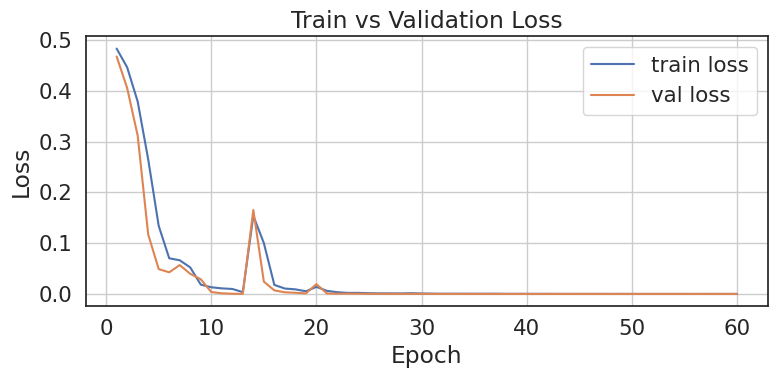

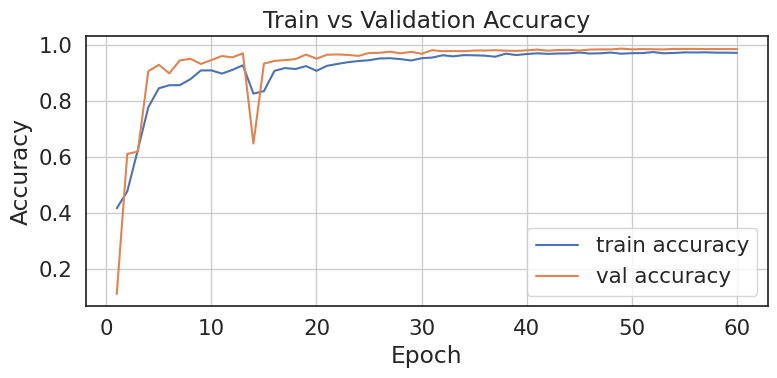

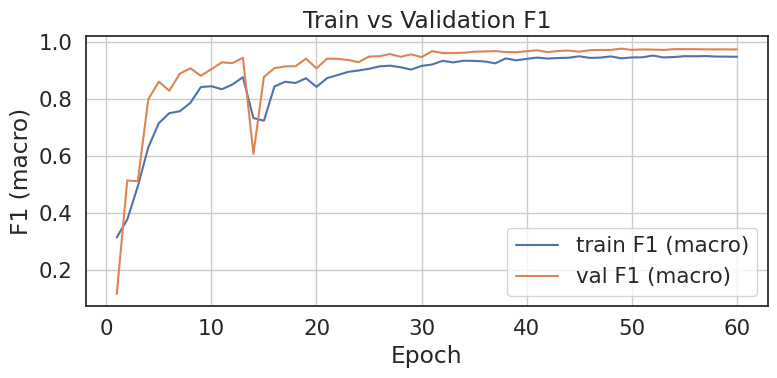

FFT-only dataset
FFT-only dataset
Saved submission to models/submission_bigru_FFT_ONLY.csv


In [ ]:
# Merge labels
labels_df = pd.DataFrame(list(labels_map.items()), columns=['sample_index', 'label'])
dataset_train_wd = dataset_train_with_disability.merge(labels_df, on='sample_index', how='left')

# Define numeric feature columns
drop_cols = {'time', 'sample_index', 'label', 'disability'}
all_num = dataset_train_wd.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in all_num if c not in drop_cols]

# Define label mappings
label_to_id = {lbl: idx for idx, lbl in enumerate(sorted(dataset_train_wd['label'].unique()))}
id_to_label = {idx: lbl for lbl, idx in label_to_id.items()}
num_classes = len(label_to_id)
print(f"Classes: {num_classes} — {label_to_id}")

# Split into train and validation sample indices
all_sids = sorted(dataset_train_wd['sample_index'].unique())
sample_labels = (
    dataset_train_wd.groupby('sample_index')['label']
    .first()
    .reindex(all_sids)
)
train_sids, val_sids = train_test_split(
    all_sids, test_size=0.2, random_state=42, stratify=sample_labels
)
print(f"Train samples: {len(train_sids)}, Validation samples: {len(val_sids)}")

# Create dataloaders FFT-only dataset
train_ds = WindowedPirateDataset(
    dataset_train_wd, feature_cols, labels_map, label_to_id,
    window_size=WIN, stride=STRIDE, train_mode=True
)
val_ds = WindowedPirateDataset(
    dataset_train_wd,
    feature_cols,
    labels_map,
    label_to_id,
    sample_indices=val_sids,
    window_size=WIN,
    stride=STRIDE,
    train_mode=False
)
test_ds = WindowedPirateDataset(
    dataset_test_with_disability, feature_cols, None, label_to_id,
    window_size=WIN, stride=STRIDE, is_test=True
)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# model creation
num_cols = len(feature_cols)
print(f"Creating FFT-only BiGRU model")

rnn_model = RecurrentClassifier(
    input_size=num_cols,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    dropout_rate=DROPOUT_RATE,
    use_film=True,
    use_pooling=USE_POOLING
).to(device)

# Optimizer and scheduler
optimizer = AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
steps_per_epoch = max(1, math.ceil(len(train_loader)))
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)

# Class weights
bigru_train_labels = []
for i in range(len(train_ds)):
    _, y, _, _ = train_ds[i]
    bigru_train_labels.append(y.item())

bigru_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=np.array(bigru_train_labels)
)
class_weights_tensor = torch.tensor(bigru_class_weights, dtype=torch.float32, device=device)
criterion = FocalLoss(weight=class_weights_tensor) if USE_FOCAL_LOSS else nn.CrossEntropyLoss(weight=class_weights_tensor)
print("Class weights tensor:", class_weights_tensor)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
best_f1 = -1
best_state = None

train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_f1s = []
val_f1s = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch_rnn(
        train_loader, rnn_model,
        optimizer=optimizer, scheduler=scheduler,
        train_mode=True
    )
    vl_loss, vl_acc, vl_f1, y_true, y_pred = run_epoch_rnn(
        val_loader, rnn_model,
        optimizer=None, scheduler=None,
        train_mode=False
    )

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train: loss={tr_loss:.4f} acc={tr_acc:.4f} f1m={tr_f1:.4f} | "
          f"val:   loss={vl_loss:.4f} acc={vl_acc:.4f} f1m={vl_f1:.4f}")

    # Store metrics for plotting
    train_losses.append(tr_loss)
    val_losses.append(vl_loss)
    train_accs.append(tr_acc)
    val_accs.append(vl_acc)
    train_f1s.append(tr_f1)
    val_f1s.append(vl_f1)

    if vl_f1 > best_f1:
        best_f1 = vl_f1
        best_state = copy.deepcopy(rnn_model.state_dict())
        os.makedirs("models", exist_ok=True)
        torch.save(
            {
                'state_dict': best_state,
                'feature_cols': feature_cols,
                'label_to_id': label_to_id,
                'id_to_label': id_to_label,
                'win': WIN,
                'stride': STRIDE
            },
            "models/best_bigru_FFT_ONLY.pt"
        )

# Validation report
if best_state is not None:
    rnn_model.load_state_dict(best_state)
vl_loss, vl_acc, vl_f1, y_true, y_pred = run_epoch_rnn(
    val_loader, rnn_model, optimizer=None, scheduler=None, train_mode=False
)
print("\nValidation classification report (best model):")
print(classification_report(
    y_true, y_pred,
    target_names=[id_to_label[i] for i in range(num_classes)],
    digits=4
))


epochs_range = range(1, len(train_losses) + 1)

# Loss curves
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_losses, label="train loss")
plt.plot(epochs_range, val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy curves (optional, but you already store them)
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_accs, label="train accuracy")
plt.plot(epochs_range, val_accs, label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# F1 curves (optional)
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_f1s, label="train F1 (macro)")
plt.plot(epochs_range, val_f1s, label="val F1 (macro)")
plt.xlabel("Epoch")
plt.ylabel("F1 (macro)")
plt.title("Train vs Validation F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Inference
rnn_model.eval()
logits_per_sid = defaultdict(list)
with torch.no_grad():
    for X, _, d, sids in test_loader:
      X = X.to(device)
      d = d.to(device)
      logits = rnn_model(X, d).detach().cpu()
      for sid, logit in zip(sids.tolist(), logits):
          logits_per_sid[sid].append(logit)

    for off in TTA_OFFSETS:
        if off == 0:
            continue
        tta_ds  = WindowedPirateDataset(dataset_test_with_disability, feature_cols, None, label_to_id,
                                        sample_indices=sorted(dataset_test_with_disability['sample_index'].unique()),
                                        window_size=WIN, stride=STRIDE, is_test=True, train_mode=False, start_offset=off)
        tta_dl  = DataLoader(tta_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
        for X, _, d, sids in tta_dl:
          X = X.to(device)
          d = d.to(device)
          logits = rnn_model(X, d).detach().cpu()
          for sid, logit in zip(sids.tolist(), logits):
              logits_per_sid[sid].append(logit)

pred_rows = []
for sid, chunks in sorted(logits_per_sid.items()):
    L = torch.stack(chunks, dim=0)
    mean_logits = L.mean(dim=0)
    pred_id = int(mean_logits.argmax().item())
    pred_label = id_to_label[pred_id]
    pred_rows.append({'sample_index': sid, 'label': pred_label})

submission = pd.DataFrame(pred_rows)
# Saving new submission
submission.to_csv("models/submission_bigru_FFT_ONLY.csv", index=False)
print("Saved submission to models/submission_bigru_FFT_ONLY.csv")

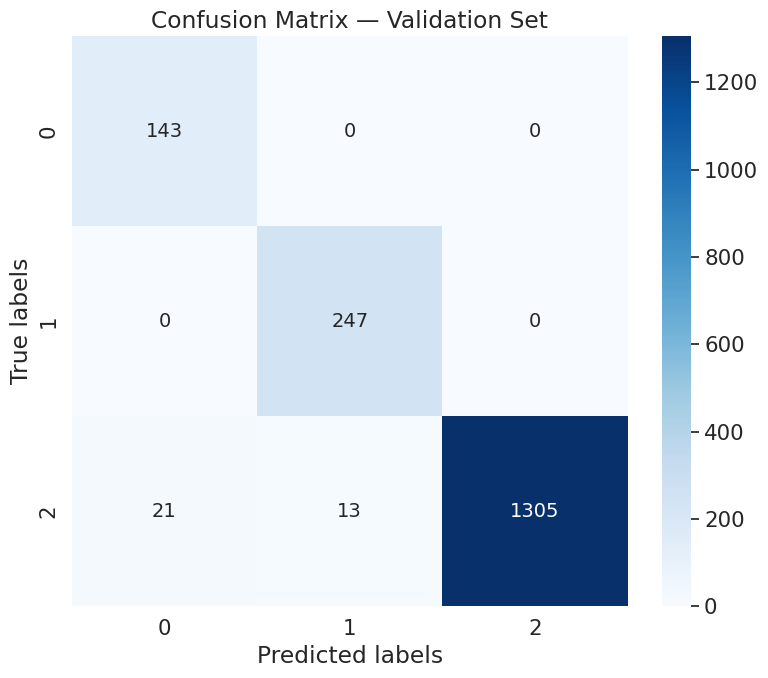

In [ ]:
# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(y_true, y_pred)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

#**LSTM**

In [ ]:
#1 Labels
# Map the string labels to integer values
label_to_id = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
id_to_label = {v: k for k, v in label_to_id.items()}
num_classes = len(label_to_id)

# Apply the mapping to your label dataframe
dataset_labels['label_id'] = dataset_labels['label'].map(label_to_id)

# 2. Define the feature columns ---
# These are the columns that remain *after* your cleaning [cite: 1690, 1699] and we exclude 'sample_index' and 'time'

feature_cols = [col for col in dataset_train_clean.columns if col not in ['sample_index', 'time', 'n_legs', 'n_hands', 'n_eyes']]
print(f"We will use {len(feature_cols)} columns of features")

# 3. Define Global Hyperparameters
WIN_SIZE = 160       # Each sample has 160 time steps
STRIDE = 1           # We don't need stride here (I think)
BATCH_SIZE = 64      # You can adjust this (64 or 128 is a good starting point)
HIDDEN_SIZE = 128    # Neurons in the LSTM
NUM_LAYERS = 2       # LSTM layers
DROPOUT_RATE = 0.2   # Dropout for regularization
LEARNING_RATE = 1e-3 # Learning rate
EPOCHS = 50          # Number of epochs (add early stopping later)
PATIENCE = 50        # Patience for early stopping

We will use 22 columns of features


In [ ]:
all_sample_indices = dataset_labels['sample_index'].unique()
labels_for_split = dataset_labels['label_id'].values

# Split the sample IDs (stratified by pain label)
# This ensures that the proportion of 'no_pain', 'low_pain' and 'high_pain' is similar in both sets.
train_ids, val_ids = train_test_split(
    all_sample_indices,
    test_size=0.2, # 20% for validation
    random_state=SEED,
    stratify=labels_for_split
)

print(f"Total of people: {len(all_sample_indices)}")
print(f"For training: {len(train_ids)}")
print(f"For validation: {len(val_ids)}")

Total of people: 661
For training: 528
For validation: 133


In [ ]:
# Lookup dictionary for the labels (id -> label)
# Created from the label dataframe
labels_dict = dataset_labels.set_index('sample_index')['label_id'].to_dict()
# We group the main dataframe by 'sample_index' for super-fast access
# we use the cleaned dataframe
grouped_train_features = dataset_train_with_disability.groupby('sample_index')

def create_dataset_from_ids(ids, features_grouped, feature_cols):
    """
    Create tensors X (features) and y (labels) from a list of sample IDs.
    """
    X_list = []
    y_list = []

    for sample_id in ids:
        # Get the sequence of 160 time steps for this ID
        sequence_df = features_grouped.get_group(sample_id)

        # Select only the feature columns and convert to numpy
        # Shape will be (160, num_features)
        features_np = sequence_df[feature_cols].values

        # Add to the list
        X_list.append(features_np)

        # Get the corresponding label (a single number: 0, 1, or 2)
        label = labels_dict[sample_id]
        y_list.append(label)

    # Convert lists to PyTorch tensors
    # X shape: (N, 160, num_features) -> e.g. [528, 160, 27]
    # y shape: (N) -> e.g. [528]
    X_tensor = torch.tensor(np.array(X_list), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(y_list), dtype=torch.long)

    return X_tensor, y_tensor

#Create datasets
print("Create tensor for training...")
X_train, y_train = create_dataset_from_ids(train_ids, grouped_train_features, feature_cols)
print("Create tensor for validation...")
X_val, y_val = create_dataset_from_ids(val_ids, grouped_train_features, feature_cols)

print(f"\nForma de X_train (features): {X_train.shape}")
print(f"Forma de y_train (labels): {y_train.shape}")
print(f"Forma de X_val (features): {X_val.shape}")
print(f"Forma de y_val (labels): {y_val.shape}")

# Create DataLoaders
# TensorDataset combines the tensors X and y into a dataset.
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

# DataLoader load in batches and shuffle
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

Create tensor for training...
Create tensor for validation...

Forma de X_train (features): torch.Size([528, 160, 22])
Forma de y_train (labels): torch.Size([528])
Forma de X_val (features): torch.Size([133, 160, 22])
Forma de y_val (labels): torch.Size([133])


In [ ]:
# 3.5: Aply SMOTE for balance 'high_pain' y 'low_pain'because high pain is not getting results
!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

# SMOTE works on 2D data (n_samples, n_features)
# Our data is 3D (n_samples, 160, 22)

# 1. Save the original 3D shape
n_samples, n_timesteps, n_features = X_train.shape

# 2. Flatten X_train to 2D
# (n_samples, 160 * 22)
X_train_2d = X_train.reshape(n_samples, n_timesteps * n_features)

# 3. Initialize SMOTE
smote = SMOTE(random_state=SEED, k_neighbors=5)
# k_neighbors must be smaller than the smallest class (high_pain)
# First, let's find out how many 'high_pain' samples you have in the training set:
n_high_pain_train = (y_train == label_to_id['high_pain']).sum().item()

if n_high_pain_train <= smote.k_neighbors:
# If you have very few samples (e.g., 5 or fewer), SMOTE will raise an error.
# We reduce k_neighbors to a safe value.

    smote.k_neighbors = max(1, n_high_pain_train - 1)
    print(f"WARNING: Few 'high_pain' samples ({n_high_pain_train}). Adjusting SMOTE k_neighbors to {smote.k_neighbors}.")

if smote.k_neighbors > 0:
    print(f"Original shape of X_train (2D): {X_train_2d.shape}")
    print(f"Original distribution of y_train: {np.bincount(y_train)}")

    # 4. Apply SMOTE
    # This creates new synthetic samples for 'high_pain' and 'low_pain'
    # until they match the number of 'no_pain' samples.

    X_train_smote_2d, y_train_smote = smote.fit_resample(X_train_2d, y_train)

    print(f"\nShape of X_train after SMOTE (2D): {X_train_smote_2d.shape}")
    print(f"Distribution of y_train after SMOTE: {np.bincount(y_train_smote)}")

   # 5. Reshape the oversampled X_train back to 3D
    X_train_smote_3d = X_train_smote_2d.reshape(-1, n_timesteps, n_features)

    # RE-CREATE THE TRAINING DATALOADER
    # We use the new SMOTE data
    train_ds = TensorDataset(torch.tensor(X_train_smote_3d, dtype=torch.float32),
                             torch.tensor(y_train_smote, dtype=torch.long))

    val_ds = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

Original shape of X_train (2D): torch.Size([528, 3520])
Original distribution of y_train: [408  75  45]

Shape of X_train after SMOTE (2D): (1224, 3520)
Distribution of y_train after SMOTE: [408 408 408]

¡DataLoaders data from SMOTE (training) y original data (validation)!


In [ ]:

class RecurrentClassifier(nn.Module):
    """
    Clasificador RNN  (RNN, LSTM, GRU)
    """
    def __init__(
        self,
        input_size,         # N° features
        hidden_size,        # N° neurons in hiddden layer
        num_layers,         # N° layers
        num_classes,        # N° clases output (ej. 3 para 'no_pain', 'low_pain', 'high_pain')
        rnn_type='GRU',     # RNN to use: 'RNN', 'LSTM', o 'GRU'
        bidirectional=False,# if True,  RNN = bidireccional
        dropout_rate=0.2
    ):
        super().__init__()
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map to selecct the correct PyTorch
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
        if rnn_type not in rnn_map:
            raise ValueError("rnn_type debe ser 'RNN', 'LSTM', o 'GRU'")
        rnn_module = rnn_map[rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0
        # 1. Recurrent Layer
        # This is the main layer (use LSTM)
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,         # Specify that the input shape is (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # 2. Classification Layer
        # Compute the input size for the final layer
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concatena adelante y atrás
        else:
            classifier_input_size = hidden_size
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
    # x shape: (batch_size, seq_length, input_size)
    # rnn_out contains the outputs from *each* time step
    # hidden contains the *final* hidden state
    # rnn_out shape: (batch, seq_len, hidden_size * num_directions)
    # hidden shape: (num_layers * num_directions, batch, hidden_size)
        rnn_out, hidden = self.rnn(x)
        if self.rnn_type == 'LSTM':
            hidden = hidden[0] # we take only h_n

        # 'hidden' is now the hidden state h_n
        # shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # We want the final hidden state from the last layer, from both directions
            # Rearrange to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            # Concatenate the last forward (hidden[-1, 0, ...]) and backward (hidden[-1, 1, ...]) states
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # If not bidirectional, we just take the hidden state from the last layer
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Pass the final hidden state vector through the classifier
        logits = self.classifier(hidden_to_classify)
        return logits

In [ ]:

classes = np.unique(dataset_labels['label'])
class_weights_calc = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=dataset_labels['label']
)
class_weights_map = dict(zip(classes, class_weights_calc))
print(f"Calculates weights : {class_weights_map}")

class_weights_tensor = torch.tensor([class_weights_map[c] for c in classes], dtype=torch.float).to(device)
print(f"Weight tensor created on the device: {class_weights_tensor.device}")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print("\n # Criterion created with class weights:")
print(criterion) #show the weights

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_predictions), average='weighted')
    return epoch_loss, epoch_f1

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_predictions), average='weighted')
    return epoch_loss, epoch_f1

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device, patience, experiment_name):
    training_history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []}
    patience_counter = 0
    best_metric = -1.0
    best_epoch = 0
    print(f"Start training for {experiment_name}...")
    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        val_loss, val_f1 = validate_one_epoch(model, val_loader, criterion, device)
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)
        print(f"Epoch {epoch:02d}/{epochs} | Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | Val: Loss={val_loss:.4f}, F1={val_f1:.4f}")

        if val_f1 > best_metric:
            best_metric = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), f"models/{experiment_name}_best.pt")
            print(f"  -> new best F1-score: {best_metric:.4f}. saved.")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping activado después de {epoch} epochs.")
                break

    print(f"\nTraining Finish. Best F1-score: {best_metric:.4f} (find on epoch {best_epoch})")
    try:
        model.load_state_dict(torch.load(f"models/{experiment_name}_best.pt"))
        print(f"best model /{experiment_name}_best.pt'")
    except Filefail")
    return model, training_history

print("\nFunction 'fit', 'train_one_epoch' y 'validate_one_epoch' defined.")

Pesos calculados : {'high_pain': np.float64(3.9345238095238093), 'low_pain': np.float64(2.3439716312056738), 'no_pain': np.float64(0.43118069145466403)}
Weight tensor created on the device: cuda:0

 # Criterion created with class weights:
CrossEntropyLoss()

Funciones 'fit', 'train_one_epoch' y 'validate_one_epoch' definidas.


In [ ]:

!mkdir -p models

#1. Instantiate the LSTM Model
lstm_model = RecurrentClassifier(
    input_size=len(feature_cols), # N° features
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    rnn_type='LSTM',          # <--- define LSTM
    bidirectional=True,       # bidirectional or not
    dropout_rate=DROPOUT_RATE
).to(device)

# 2. Optimizer and Scaler
optimizer = optim.AdamW(lstm_model.parameters(), lr=LEARNING_RATE)
scaler = GradScaler(enabled=(device.type == 'cuda'))

# 3. Train
lstm_model, history = fit(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    patience=PATIENCE,
    experiment_name="lstm_baseline"
)

Comenzando entrenamiento para lstm_baseline...
Epoch 01/50 | Train: Loss=0.8991, F1=0.1917 | Val: Loss=0.4848, F1=0.6760
  -> Nuevo mejor F1-score: 0.6760. Modelo guardado.
Epoch 02/50 | Train: Loss=0.8514, F1=0.1667 | Val: Loss=0.5039, F1=0.6760
Epoch 03/50 | Train: Loss=0.7956, F1=0.2633 | Val: Loss=0.5476, F1=0.7196
  -> Nuevo mejor F1-score: 0.7196. Modelo guardado.
Epoch 04/50 | Train: Loss=0.8442, F1=0.3194 | Val: Loss=0.4743, F1=0.6760
Epoch 05/50 | Train: Loss=0.7840, F1=0.2742 | Val: Loss=0.6339, F1=0.6717
Epoch 06/50 | Train: Loss=0.8216, F1=0.3121 | Val: Loss=0.4645, F1=0.6932
Epoch 07/50 | Train: Loss=0.7517, F1=0.2674 | Val: Loss=0.5099, F1=0.7142
Epoch 08/50 | Train: Loss=0.6776, F1=0.3797 | Val: Loss=0.9346, F1=0.4121
Epoch 09/50 | Train: Loss=0.6691, F1=0.4131 | Val: Loss=0.3413, F1=0.7571
  -> Nuevo mejor F1-score: 0.7571. Modelo guardado.
Epoch 10/50 | Train: Loss=0.6289, F1=0.4376 | Val: Loss=0.3075, F1=0.7412
Epoch 11/50 | Train: Loss=0.5942, F1=0.4237 | Val: Loss=0

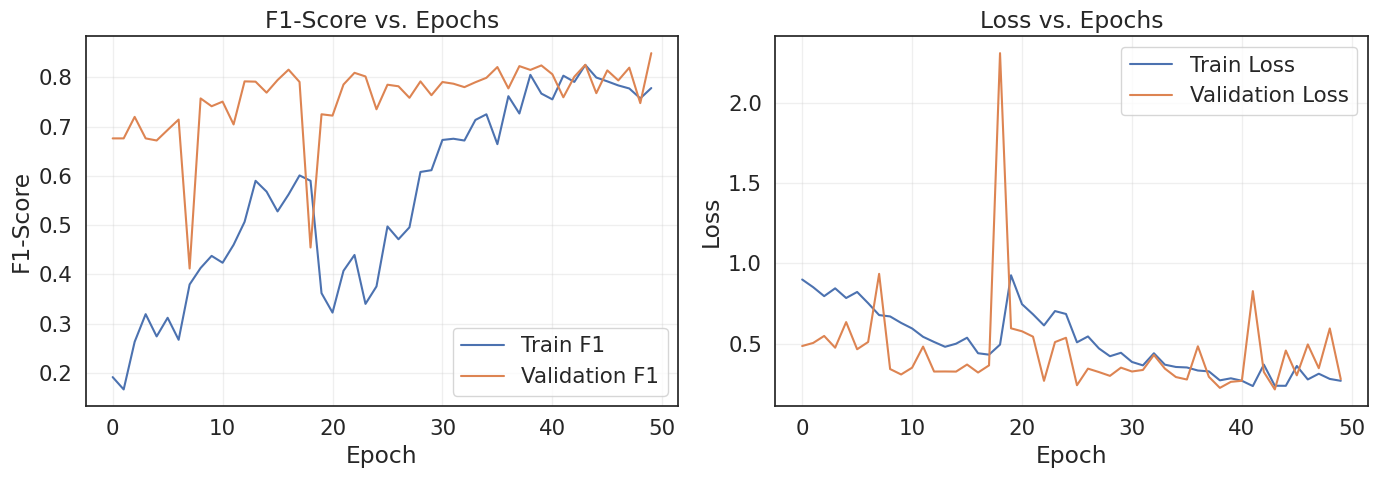


Validation classification report (LSTM):
              precision    recall  f1-score   support

     no_pain     0.8850    0.9709    0.9259       103
    low_pain     0.8000    0.6316    0.7059        19
   high_pain     0.6000    0.2727    0.3750        11

    accuracy                         0.8647       133
   macro avg     0.7617    0.6251    0.6689       133
weighted avg     0.8493    0.8647    0.8489       133



In [ ]:
def plot_history(history):
    """
    Plot F1-score and Loss of training and validation
    """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    # --- Gráfico de F1-score ---
    ax1.plot(history['train_f1'], label='Train F1')
    ax1.plot(history['val_f1'], label='Validation F1')
    ax1.set_title('F1-Score vs. Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('F1-Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    #Plot Loss
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Loss vs. Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
try:
    plot_history(history)
except NameError:
    print("variable 'history' not defined")
try:
    all_val_preds = []
    all_val_targets = []

    lstm_model.eval()

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)

            # obtein logits
            logits = lstm_model(inputs)
            predictions = logits.argmax(dim=1).cpu().numpy()

            all_val_preds.append(predictions)
            all_val_targets.append(targets.cpu().numpy())

    # Concatenated the results of the batches
    y_pred = np.concatenate(all_val_preds)
    y_true = np.concatenate(all_val_targets)
    target_names = [id_to_label[i] for i in range(num_classes)]

    print("\nValidation classification report (LSTM):")
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

except NameError as e:
    print(f"Error: {e}")
    print("make sure 'lstm_model', 'val_loader', 'id_to_label' y 'num_classes' exist.")
except Exception as e:
    print(f"error: {e}")


In [ ]:
# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(y_true, y_pred)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()